In [ ]:
# Author: Markus Viljanen

In [5]:
df = pd.read_csv('df_tox.csv')
df['fold1'] = 0
for i in range(1,5+1):
    df.loc[df['setting1_test%d' % i], 'fold1'] = i
df['fold2'] = 0
for i in range(1,5+1):
    df.loc[df['setting2_test%d' % i], 'fold2'] = i
df['index'] = df.index.values

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from scipy.stats import zscore
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import GroupKFold

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error

#### Linear model

##### Illustration of hyperparameters in the first fold

In [236]:
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/LM_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'alpha', 'rmse'])
temp = temp[temp['fold'] == 1]

Text(0.5, 0.98, 'LM model: RMSE in validation set')

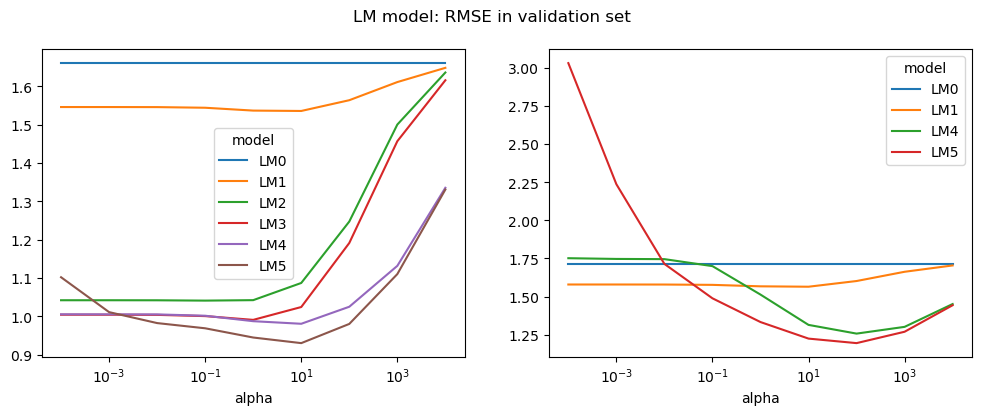

In [237]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
temp[temp['setting'] == 'setting1'].pivot(index='alpha', columns='model', values='rmse').plot(ax=ax1, logx=True)
temp[temp['setting'] == 'setting2'].drop_duplicates(['model', 'alpha']).pivot(index='alpha', columns='model', values='rmse').plot(ax=ax2, logx=True)
fig.suptitle('LM model: RMSE in validation set')

In [238]:
temp.sort_values('rmse').drop_duplicates(['setting', 'model']).sort_values(['setting', 'model'])

,model,setting,fold,alpha,rmse
28,LM0,setting1,1,0.01,1.660196
93,LM1,setting1,1,10.00,1.535527
171,LM2,setting1,1,0.10,1.041355
239,LM3,setting1,1,1.00,0.991183
270,LM4,setting1,1,10.00,0.980995
392,LM5,setting1,1,10.00,0.930593
6,LM0,setting2,1,10000.00,1.716967
145,LM1,setting2,1,10.00,1.564940
306,LM4,setting2,1,100.00,1.257587
384,LM5,setting2,1,100.00,1.195212


##### Save optimal hyperparameters in each fold

In [298]:
# Save optimal hyperparameters in each fold
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/LM_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'alpha', 'rmse'])
s = temp.sort_values('rmse').drop_duplicates(['setting', 'model', 'fold']).sort_values(['setting', 'model', 'fold'])
s[['setting', 'model', 'fold', 'alpha']].to_csv('LM_optimal.csv', index=False)

In [255]:
d = {(row['setting'],row['model'],row['fold']): {'alpha': row['alpha']} 
     for i,row in pd.read_csv('LM_optimal.csv').iterrows()} 
d[('setting1', 'LM5', 1)]

{'alpha': 10.0}

#### Factorization machine

##### Illustration of hyperparameters in the first fold (early stopping enabled)

In [289]:
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/XL_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'alpha', 'epoch', 'k', 'rmse'])
temp = temp[temp['epoch'] == 500]

In [290]:
#temp = temp.groupby(['model', 'setting', 'alpha', 'k'], as_index=False)['rmse'].mean()
temp = temp[temp['fold'] == 1]

Text(0.5, 0.98, 'Factorization machine')

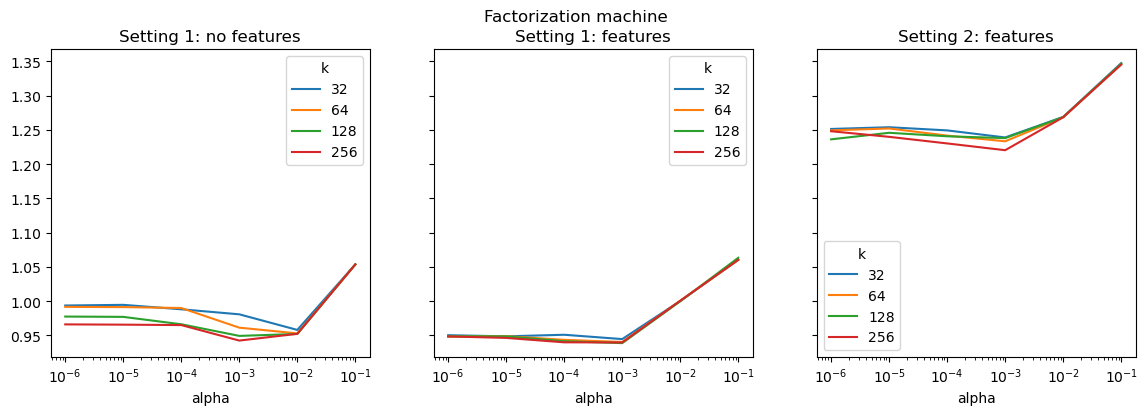

In [291]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4), sharey=True)
temp1 = temp[(temp['model'] == 'XL3a') & (temp['setting'] == 'setting1')]
temp1.pivot(index='alpha', columns='k', values='rmse').plot(ax=ax1, logx=True)
temp2 = temp[(temp['model'] == 'XL5a') & (temp['setting'] == 'setting1')]
temp2.pivot(index='alpha', columns='k', values='rmse').plot(ax=ax2, logx=True)
temp3 = temp[(temp['model'] == 'XL5a') & (temp['setting'] == 'setting2')]
temp3.pivot(index='alpha', columns='k', values='rmse').plot(ax=ax3, logx=True)
ax1.set_title('Setting 1: no features')
ax2.set_title('Setting 1: features')
ax3.set_title('Setting 2: features')
fig.suptitle('Factorization machine')

Text(0.5, 0.98, 'Field-aware Factorization machine')

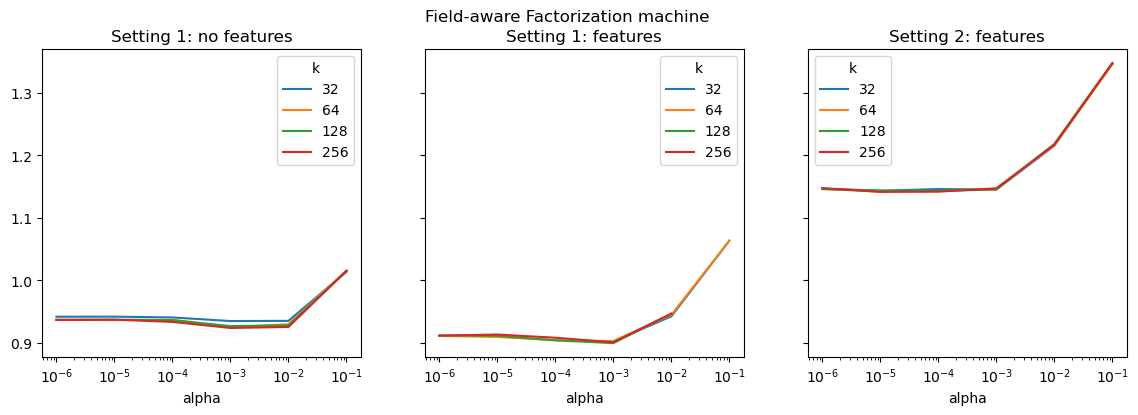

In [292]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4), sharey=True)
temp1 = temp[(temp['model'] == 'XL3b') & (temp['setting'] == 'setting1')]
temp1.pivot(index='alpha', columns='k', values='rmse').plot(ax=ax1, logx=True)
temp2 = temp[(temp['model'] == 'XL5b') & (temp['setting'] == 'setting1')]
temp2.pivot(index='alpha', columns='k', values='rmse').plot(ax=ax2, logx=True)
temp3 = temp[(temp['model'] == 'XL5b') & (temp['setting'] == 'setting2')]
temp3.pivot(index='alpha', columns='k', values='rmse').plot(ax=ax3, logx=True)
ax1.set_title('Setting 1: no features')
ax2.set_title('Setting 1: features')
ax3.set_title('Setting 2: features')
fig.suptitle('Field-aware Factorization machine')

In [293]:
temp.sort_values('rmse').drop_duplicates(['setting', 'model']).sort_values(['setting', 'model'])

,model,setting,fold,alpha,epoch,k,rmse
100,XL3a,setting1,1,0.00100,500,256,0.942452
178,XL3b,setting1,1,0.00100,500,256,0.923399
459,XL5a,setting1,1,0.00100,500,128,0.938732
607,XL5b,setting1,1,0.00100,500,128,0.899139
406,XL5a,setting2,1,0.00100,500,256,1.220410
603,XL5b,setting2,1,0.00001,500,256,1.141483


##### Illustration of hyperparameters in the first fold (early stopping not enabled)

In [329]:
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/XL_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'alpha', 'epoch', 'k', 'rmse'])
temp = temp[temp['model'].isin(['XL3a_final', 'XL3b_final', 'XL5a_final','XL5b_final'])]

In [330]:
#temp = temp.groupby(['model', 'setting', 'alpha', 'k'], as_index=False)['rmse'].mean()
temp = temp[temp['fold'] == 1]

<AxesSubplot:xlabel='epoch'>

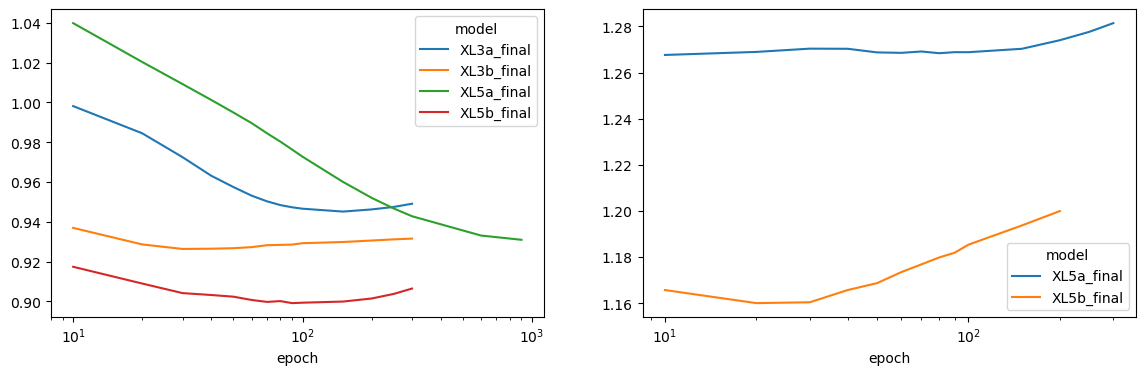

In [331]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4), sharey=False)
temp1 = temp[(temp['setting'] == 'setting1')]
temp1.pivot(index='epoch', columns='model', values='rmse').plot(ax=ax1, logx=True)
temp1 = temp[(temp['setting'] == 'setting2')]
temp1.pivot(index='epoch', columns='model', values='rmse').plot(ax=ax2, logx=True)

In [332]:
temp.sort_values('rmse').drop_duplicates(['setting', 'model']).sort_values(['setting', 'model'])

,model,setting,fold,alpha,epoch,k,rmse
889,XL3a_final,setting1,1,0.00100,150,256,0.945136
707,XL3b_final,setting1,1,0.00100,30,256,0.926352
1073,XL5a_final,setting1,1,0.00100,900,128,0.930959
1058,XL5b_final,setting1,1,0.00100,90,128,0.899141
756,XL5a_final,setting2,1,0.00100,10,256,1.267638
980,XL5b_final,setting2,1,0.00001,20,256,1.160019


##### Save optimal hyperparameters in each fold

In [333]:
# Save optimal hyperparameters in each fold
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/XL_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'alpha', 'epoch', 'k', 'rmse'])
temp = temp[temp['model'].isin(['XL3a_final', 'XL3b_final', 'XL5a_final','XL5b_final'])]
s = temp.sort_values('rmse').drop_duplicates(['setting', 'model', 'fold']).sort_values(['setting', 'model', 'fold'])
s[['setting', 'model', 'fold', 'alpha', 'k', 'epoch']].to_csv('XL_optimal_epoch.csv', index=False)

#### XGBoost

##### Illustration of hyperparameters in the first fold 

In [318]:
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/XGB_hyperparameters.csv', header=None,
                   names=['model', 'setting', 'fold', 'nrounds', 'tree_depth', 'l2', 'gamma', 'subsample', 'rmse'])
temp = temp[temp['fold'] == 1]

In [319]:
temp.sort_values('rmse').drop_duplicates(['setting', 'model']).sort_values(['setting', 'model'])

,model,setting,fold,nrounds,tree_depth,l2,gamma,subsample,rmse
1128,XGB,setting1,1,1124,9,10.0,0.1,1.00,0.856662
133,XGB,setting2,1,529,7,1.0,0.1,0.75,1.066378


In [320]:
temp[temp['setting'] == 'setting1'].sort_values('rmse').head(5)

,model,setting,fold,nrounds,tree_depth,l2,gamma,subsample,rmse
1128,XGB,setting1,1,1124,9,10.0,0.1,1.00,0.856662
1061,XGB,setting1,1,1496,7,10.0,0.1,1.00,0.864028
998,XGB,setting1,1,526,7,1.0,1.0,1.00,0.866076
1062,XGB,setting1,1,609,9,1.0,1.0,0.75,0.866901
972,XGB,setting1,1,1090,5,1.0,0.0,1.00,0.867926


In [321]:
temp[temp['setting'] == 'setting2'].sort_values('rmse').head(5)

,model,setting,fold,nrounds,tree_depth,l2,gamma,subsample,rmse
133,XGB,setting2,1,529,7,1.0,0.1,0.75,1.066378
165,XGB,setting2,1,455,9,1.0,0.0,1.00,1.084012
179,XGB,setting2,1,287,9,1.0,0.1,1.00,1.093190
227,XGB,setting2,1,450,9,1.0,0.0,0.75,1.102247
161,XGB,setting2,1,261,9,1.0,1.0,0.75,1.104849


Text(0.5, 0.98, 'XGBoost')

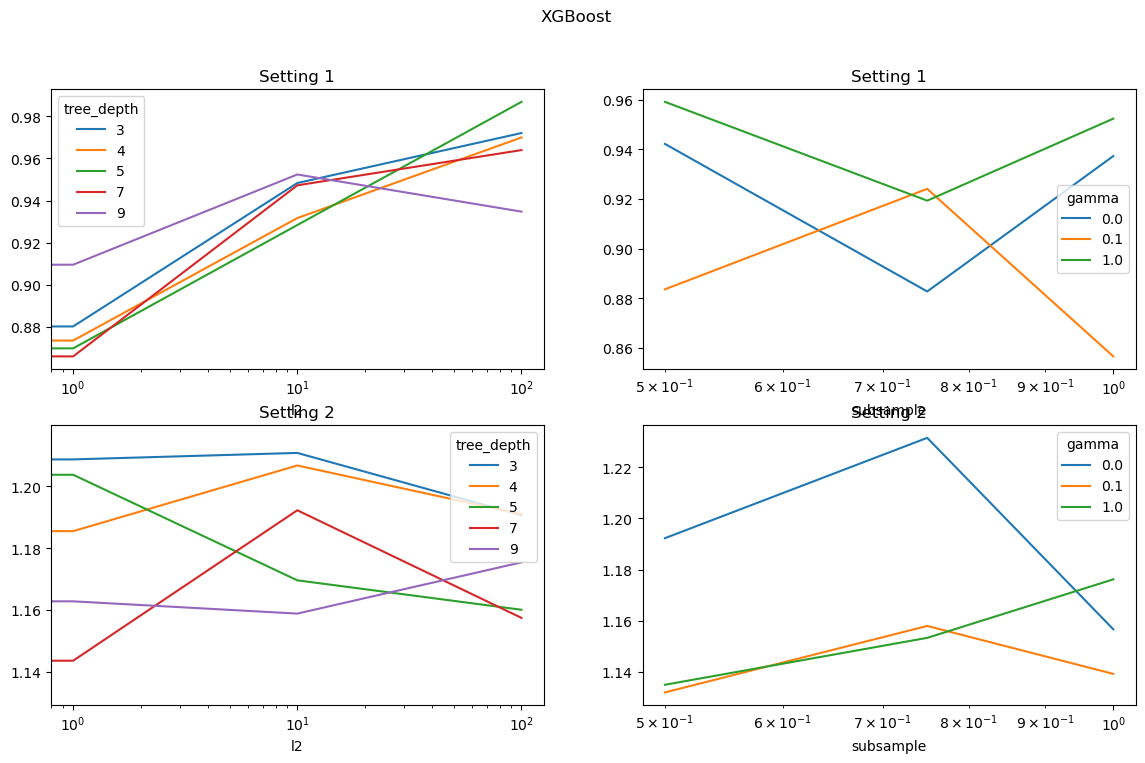

In [322]:
# plot tree_depth on l2 x-axis (gamma=0, subsample=1.0)
# plot gamma, subsample (lambda=1, tree_depth=5)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,8))
temp1 = temp[(temp['setting'] == 'setting1') & (temp['gamma'] == 1.0) & (temp['subsample'] == 1.00)] 
temp1.pivot(index='l2', columns='tree_depth', values='rmse').plot(ax=ax1, logx=True)
temp2 = temp[(temp['setting'] == 'setting1') & (temp['l2'] == 10.0) & (temp['tree_depth'] == 9)]
temp2.pivot(index='subsample', columns='gamma', values='rmse').plot(ax=ax2, logx=True)
temp1 = temp[(temp['setting'] == 'setting2') & (temp['gamma'] == 0) & (temp['subsample'] == 0.5)]
temp1.pivot(index='l2', columns='tree_depth', values='rmse').plot(ax=ax3, logx=True)
temp2 = temp[(temp['setting'] == 'setting2') & (temp['l2'] == 10) & (temp['tree_depth'] == 7)]
temp2.pivot(index='subsample', columns='gamma', values='rmse').plot(ax=ax4, logx=True)
ax1.set_title('Setting 1')
ax2.set_title('Setting 1')
ax3.set_title('Setting 2')
ax4.set_title('Setting 2')
fig.suptitle('XGBoost')

##### Save optimal hyperparameters in each fold

In [323]:
# Save optimal hyperparameters in each fold
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/XGB_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'nrounds', 'tree_depth', 'l2', 'gamma', 'subsample', 'rmse'])
s = temp.sort_values('rmse').drop_duplicates(['setting', 'model', 'fold']).sort_values(['setting', 'model', 'fold'])
s[['setting', 'model', 'fold', 'nrounds', 'tree_depth', 'l2', 'gamma', 'subsample']].to_csv('XGB_optimal.csv', index=False)

#### Tensorflow

##### Illustration of hyperparameters in the first fold 

In [344]:
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/TF_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'M', 'penalty', 'nrounds', 'rmse'])

In [346]:
temp = temp[temp['fold'] == 1]

Text(0.5, 0.98, 'Tensorflow')

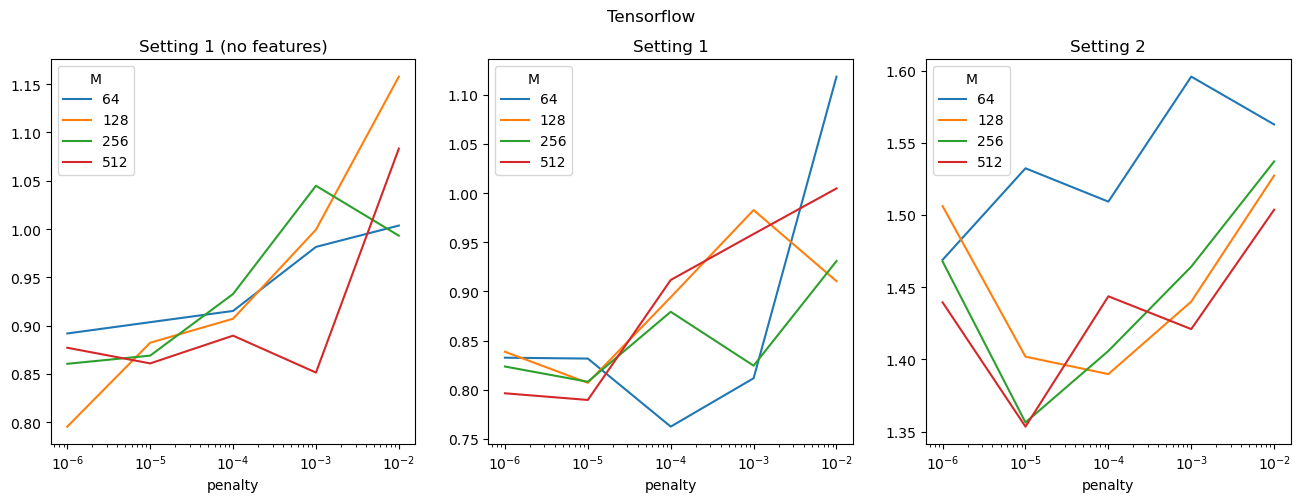

In [347]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(16,5))
temp1 = temp[(temp['setting'] == 'setting1') & (temp['model'] == 'TF3')] 
temp1.pivot(index='penalty', columns='M', values='rmse').plot(ax=ax0, logx=True)
temp1 = temp[(temp['setting'] == 'setting1') & (temp['model'] == 'TF5')] 
temp1.pivot(index='penalty', columns='M', values='rmse').plot(ax=ax1, logx=True)
temp2 = temp[(temp['setting'] == 'setting2') & (temp['model'] == 'TF5')]
temp2.pivot(index='penalty', columns='M', values='rmse').plot(ax=ax2, logx=True)
ax0.set_title('Setting 1 (no features)')
ax1.set_title('Setting 1')
ax2.set_title('Setting 2')
fig.suptitle('Tensorflow')

In [348]:
temp.sort_values('rmse').drop_duplicates(['setting', 'model']).sort_values(['setting', 'model'])

,model,setting,fold,M,penalty,nrounds,rmse
4,TF3,setting1,1,128,0.000001,20,0.795676
102,TF5,setting1,1,64,0.000100,15,0.762476
216,TF5,setting2,1,512,0.000010,10,1.353383


##### Save optimal hyperparameters in each fold

In [349]:
# Save optimal hyperparameters in each fold
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/TF_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'M', 'penalty', 'nrounds', 'rmse'])
s = temp.sort_values('rmse').drop_duplicates(['setting', 'model', 'fold']).sort_values(['setting', 'model', 'fold'])
s[['setting', 'model', 'fold', 'M', 'penalty', 'nrounds']].to_csv('TF_optimal.csv', index=False)

#### SVR

##### Illustration of hyperparameters in the first fold 

In [367]:
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/SVR_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'M', 'penalty', 'gamma', 'rmse'])

In [368]:
temp = temp[temp['fold'] == 1]

In [369]:
temp[(temp['setting'] == 'setting1')].sort_values('rmse').head()

,model,setting,fold,M,penalty,gamma,rmse
419,SVR,setting1,1,0.0,10.0,0.08,0.920601
560,SVR,setting1,1,0.0,100.0,0.02,0.925791
445,SVR,setting1,1,0.0,100.0,0.08,0.925924
450,SVR,setting1,1,0.0,10000.0,0.08,0.926126
447,SVR,setting1,1,0.0,1000.0,0.08,0.926129


In [370]:
temp[temp['setting'] == 'setting2'].sort_values('rmse').head()

,model,setting,fold,M,penalty,gamma,rmse
489,SVR,setting2,1,0.0,10.0,0.08,1.198481
594,SVR,setting2,1,0.0,1000.0,0.08,1.206027
600,SVR,setting2,1,0.0,10000.0,0.08,1.210290
566,SVR,setting2,1,0.0,100.0,0.08,1.210422
1513,SVR,setting2,1,8000.0,1.0,0.02,1.236489


Text(0.5, 1.0, 'SVR: setting1')

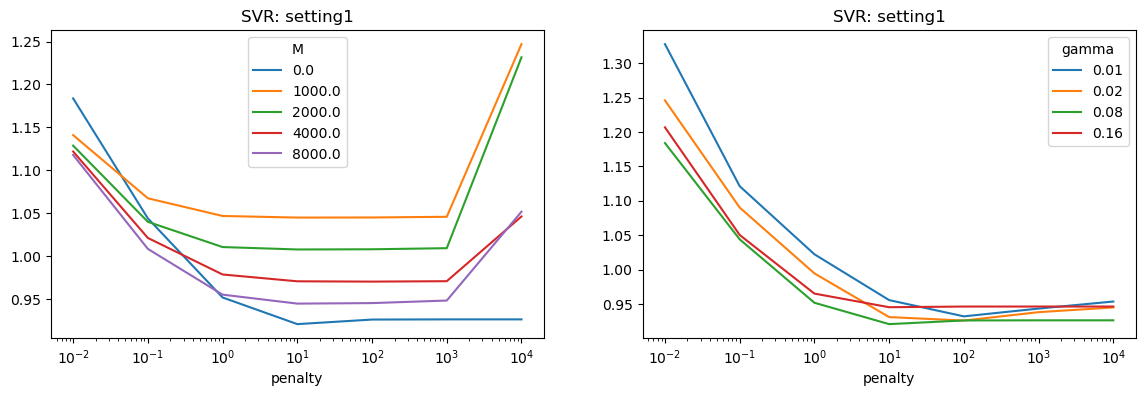

In [371]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4), sharey=False)
temp1 = temp[(temp['setting'] == 'setting1') & (temp['gamma'] == 0.08)] 
temp1.pivot(index='penalty', columns='M', values='rmse').plot(ax=ax1, logx=True).set_title('SVR: setting1')
temp1 = temp[(temp['setting'] == 'setting1') & (temp['M'] == 0)] 
temp1.pivot(index='penalty', columns='gamma', values='rmse').plot(ax=ax2, logx=True).set_title('SVR: setting1')

Text(0.5, 1.0, 'SVR: setting2')

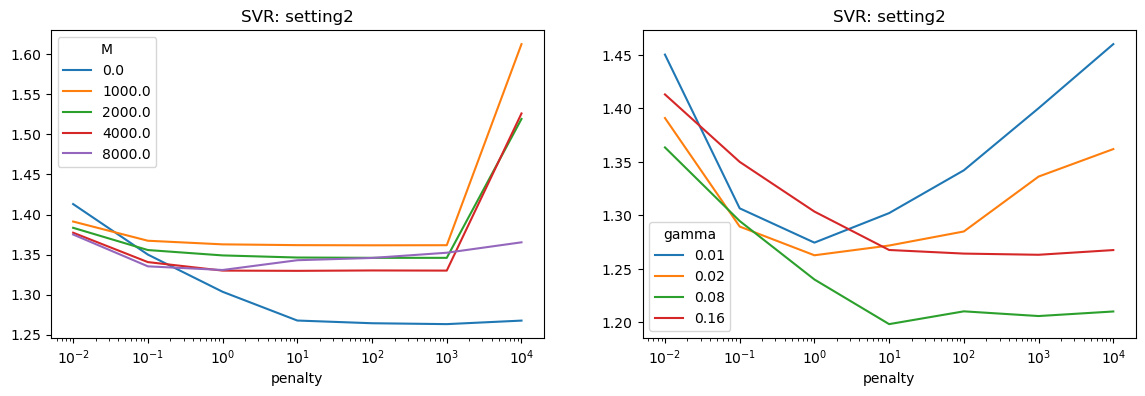

In [372]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4), sharey=False)
temp2 = temp[(temp['setting'] == 'setting2') & (temp['gamma'] == 0.16)] 
temp2.pivot(index='penalty', columns='M', values='rmse').plot(ax=ax1, logx=True).set_title('SVR: setting2')
temp1 = temp[(temp['setting'] == 'setting2') & (temp['M'] == 0)] 
temp1.pivot(index='penalty', columns='gamma', values='rmse').plot(ax=ax2, logx=True).set_title('SVR: setting2')

In [373]:
temp.sort_values('rmse').drop_duplicates(['setting', 'model']).sort_values(['setting', 'model'])

,model,setting,fold,M,penalty,gamma,rmse
419,SVR,setting1,1,0.0,10.0,0.08,0.920601
489,SVR,setting2,1,0.0,10.0,0.08,1.198481


##### Save optimal hyperparameters in each fold

In [430]:
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/SVR_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'M', 'penalty', 'gamma', 'rmse'])
temp = temp[temp['M'] == 0.00]
s = temp.sort_values('rmse').drop_duplicates(['setting', 'model', 'fold']).sort_values(['setting', 'model', 'fold'])
s[['setting', 'model', 'fold', 'M', 'penalty', 'gamma']].to_csv('SVR_optimal.csv', index=False)

#### Illustrate the importance of SVR hyperparameters

In [2]:
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/SVR_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'M', 'penalty', 'gamma', 'rmse'])

In [3]:
temp = temp[(temp['fold'].isin([1,2,3,4,5])) & (temp['M'] <= 10000)].copy()
temp1 = temp[(temp['setting'] == 'setting1') & (temp['gamma'] == 0.08)].copy()

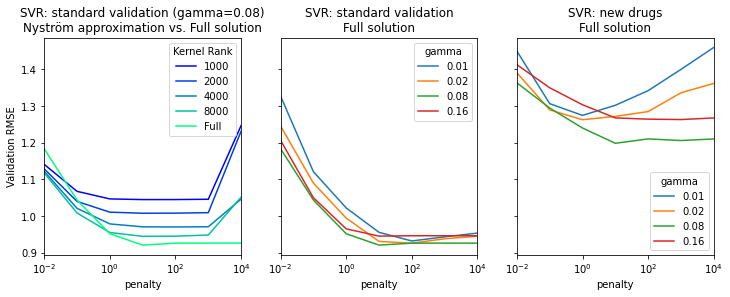

In [11]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(12,4), sharey=True)
temp1 = temp[(temp['setting'] == 'setting1') & (temp['gamma'] == 0.08) & (temp['fold'] == 1)].copy()
temp1.loc[temp1['M'] == 0, 'M'] = int(len(df)*0.9)
s = 'SVR: standard validation (gamma=0.08)\nNyström approximation vs. Full solution'
s1 = 'SVR: standard validation\nFull solution'
s2 = 'SVR: new drugs\nFull solution'
xx = temp1.pivot(index='penalty', columns='M', values='rmse')
xx.columns = ["1000", "2000", "4000", "8000", "Full"]
xx.plot(ax=ax0, logx=True, cmap='winter').set_title(s)
temp1 = temp[(temp['setting'] == 'setting1') & (temp['M'] == 0) & (temp['gamma'] <= 0.32) & (temp['fold'] == 1)] 
temp1.pivot(index='penalty', columns='gamma', values='rmse').plot(ax=ax1, logx=True).set_title(s1)
temp1 = temp[(temp['setting'] == 'setting2') & (temp['M'] == 0) & (temp['gamma'] <= 0.32) & (temp['fold'] == 1)] 
temp1.pivot(index='penalty', columns='gamma', values='rmse').plot(ax=ax2, logx=True).set_title(s2)
ax0.set_xlim(0.01, 10000)
ax1.set_xlim(0.01, 10000)
ax2.set_xlim(0.01, 10000)
ax0.set_ylabel('Validation RMSE')
ax0.legend(loc='upper right', title='Kernel Rank')
ax2.legend(loc='lower right', title='gamma')

fig.savefig('SVR.png')
fig.savefig('SVR.pdf', bbox_inches='tight')

#### Random Forest

##### Illustration of hyperparameters in the first fold 

In [389]:
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/RF_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'n_estimators', 'max_features', 'max_samples', 'rmse'])
temp['max_samples'] = temp['max_samples'].fillna(2.00)

In [390]:
temp = temp[temp['fold'] == 1]

<AxesSubplot:xlabel='max_features'>

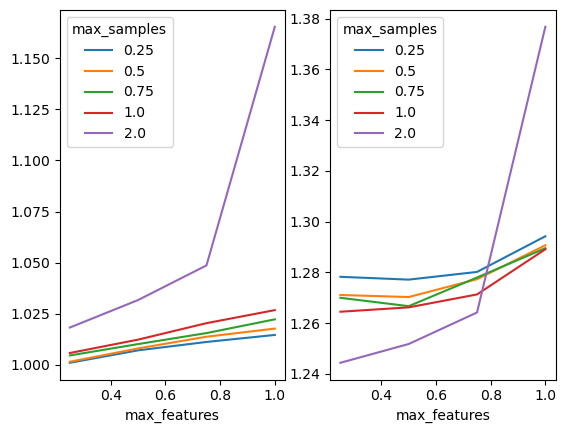

In [391]:
fig, (ax1, ax2) = plt.subplots(1,2)
temp1  = temp[(temp['n_estimators'] == 300) & (temp['setting'] == 'setting1')]
temp1.pivot(index='max_features', columns='max_samples', values='rmse').plot(ax=ax1)
temp2  = temp[(temp['n_estimators'] == 300) & (temp['setting'] == 'setting2')]
temp2.pivot(index='max_features', columns='max_samples', values='rmse').plot(ax=ax2)

In [392]:
temp.sort_values('rmse').drop_duplicates(['setting', 'model']).sort_values(['setting', 'model'])

,model,setting,fold,n_estimators,max_features,max_samples,rmse
50,RF,setting1,1,300.0,0.25,0.25,1.001016
66,RF,setting2,1,300.0,0.25,2.00,1.244410


##### Save optimal hyperparameters in each fold

In [393]:
temp = pd.read_csv('/mnt/scratch_dir/viljanem/hyperparameters/RF_hyperparameters.csv', header=None, 
                   names=['model', 'setting', 'fold', 'n_estimators', 'max_features', 'max_samples', 'rmse'])
temp['max_samples'] = temp['max_samples'].fillna(2.00)
temp = temp[temp['fold'].isin([1,2,3,4,5])]
s = temp.sort_values('rmse').drop_duplicates(['setting', 'model', 'fold']).sort_values(['setting', 'model', 'fold'])
s[['setting', 'model', 'fold', 'n_estimators', 'max_features', 'max_samples']].to_csv('RF_optimal.csv', index=False)

#### Optimal hyperparameters

In [45]:
temp = pd.read_csv('LM_optimal.csv')
temp = temp[temp['model'].isin(['LM4'])]
temp.replace({'model': {'LM4': 'LM'}})

,setting,model,fold,alpha
20,setting1,LM,1,10.0
21,setting1,LM,2,10.0
22,setting1,LM,3,10.0
23,setting1,LM,4,10.0
24,setting1,LM,5,10.0
40,setting2,LM,1,100.0
41,setting2,LM,2,100.0
42,setting2,LM,3,100.0
43,setting2,LM,4,100.0
44,setting2,LM,5,100.0


In [47]:
temp = pd.read_csv('LM_optimal.csv')
temp = temp[temp['model'].isin(['LM5'])]
temp.replace({'model': {'LM5': 'LM (interactions)'}})

,setting,model,fold,alpha
25,setting1,LM (interactions),1,10.0
26,setting1,LM (interactions),2,10.0
27,setting1,LM (interactions),3,10.0
28,setting1,LM (interactions),4,10.0
29,setting1,LM (interactions),5,10.0
45,setting2,LM (interactions),1,100.0
46,setting2,LM (interactions),2,100.0
47,setting2,LM (interactions),3,100.0
48,setting2,LM (interactions),4,100.0
49,setting2,LM (interactions),5,100.0


In [40]:
temp = pd.read_csv('XL_optimal_epoch.csv')
temp = temp[temp['model'].isin(['XL5b_final'])]
temp.replace({'model': {'XL5b_final': 'FM'}})

,setting,model,fold,alpha,k,epoch
15,setting1,FM,1,0.001000,128,90
16,setting1,FM,2,0.001000,256,50
17,setting1,FM,3,0.001000,128,50
18,setting1,FM,4,0.001000,128,40
19,setting1,FM,5,0.001000,256,30
25,setting2,FM,1,0.000010,256,20
26,setting2,FM,2,0.000001,128,30
27,setting2,FM,3,0.001000,128,50
28,setting2,FM,4,0.000100,128,100
29,setting2,FM,5,0.001000,128,10


In [41]:
temp = pd.read_csv('XGB_optimal.csv')
temp.replace({'model': {'XL5b_final': 'FM'}})

,setting,model,fold,nrounds,tree_depth,l2,gamma,subsample
0,setting1,XGB,1,1124,9,10.0,0.1,1.00
1,setting1,XGB,2,937,7,10.0,0.0,0.75
2,setting1,XGB,3,567,9,1.0,0.0,0.75
3,setting1,XGB,4,707,7,1.0,1.0,0.75
4,setting1,XGB,5,636,7,10.0,0.0,0.75
5,setting2,XGB,1,529,7,1.0,0.1,0.75
6,setting2,XGB,2,184,9,0.0,1.0,1.00
7,setting2,XGB,3,241,7,10.0,0.1,1.00
8,setting2,XGB,4,142,9,0.0,0.0,0.50
9,setting2,XGB,5,192,9,10.0,0.1,0.75


In [42]:
temp = pd.read_csv('TF_optimal.csv')
temp = temp[temp['model'].isin(['TF5'])]
temp.replace({'model': {'TF5': 'NN'}})

,setting,model,fold,M,penalty,nrounds
5,setting1,NN,1,64,0.000100,15
6,setting1,NN,2,256,0.000001,24
7,setting1,NN,3,512,0.000010,23
8,setting1,NN,4,128,0.000001,21
9,setting1,NN,5,256,0.000010,14
10,setting2,NN,1,512,0.000010,10
11,setting2,NN,2,512,0.000100,24
12,setting2,NN,3,128,0.000001,18
13,setting2,NN,4,512,0.000010,13
14,setting2,NN,5,512,0.000001,9


In [43]:
pd.read_csv('SVR_optimal.csv')

,setting,model,fold,M,penalty,gamma
0,setting1,SVR,1,0.0,10.0,0.08
1,setting1,SVR,2,0.0,100.0,0.02
2,setting1,SVR,3,0.0,100.0,0.02
3,setting1,SVR,4,0.0,100.0,0.02
4,setting1,SVR,5,0.0,100.0,0.02
5,setting2,SVR,1,0.0,10.0,0.08
6,setting2,SVR,2,0.0,10.0,0.08
7,setting2,SVR,3,0.0,10.0,0.08
8,setting2,SVR,4,0.0,10.0,0.08
9,setting2,SVR,5,0.0,10.0,0.08


In [44]:
pd.read_csv('RF_optimal.csv')

,setting,model,fold,n_estimators,max_features,max_samples
0,setting1,RF,1,300.0,0.25,0.25
1,setting1,RF,2,300.0,0.25,0.50
2,setting1,RF,3,300.0,0.25,0.50
3,setting1,RF,4,300.0,0.25,0.50
4,setting1,RF,5,300.0,0.25,0.50
5,setting2,RF,1,300.0,0.25,2.00
6,setting2,RF,2,300.0,0.25,2.00
7,setting2,RF,3,300.0,0.25,2.00
8,setting2,RF,4,300.0,0.25,2.00
9,setting2,RF,5,300.0,0.25,2.00
